In [28]:
from google.cloud import bigquery
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'DejaVu Sans'
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from yellowbrick.cluster import KElbowVisualizer

In [3]:
# Set up BigQuery client
client = bigquery.Client(project="mlops-retail-quant")

# Query the data from BigQuery
query = """
SELECT * FROM `mlops-retail-quant.retail_dataset.raw_data_table`
"""
df = client.query(query).to_dataframe()

# Display the dataframe
df.head()


,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
0,536414,22139,None,56,2010-12-01 11:52:00+00:00,0.0,<NA>,United Kingdom
1,536545,21134,None,1,2010-12-01 14:32:00+00:00,0.0,<NA>,United Kingdom
2,536546,22145,None,1,2010-12-01 14:33:00+00:00,0.0,<NA>,United Kingdom
3,536547,37509,None,1,2010-12-01 14:33:00+00:00,0.0,<NA>,United Kingdom
4,536549,85226A,None,1,2010-12-01 14:34:00+00:00,0.0,<NA>,United Kingdom


In [4]:
df.shape

(541909, 8)

In [5]:
df.dtypes

invoice_no                   object
stock_code                   object
description                  object
quantity                      Int64
invoice_date    datetime64[us, UTC]
unit_price                  float64
customer_id                   Int64
country                      object
dtype: object

In [6]:
print(df.isnull().sum()[df.isnull().sum()>0].sort_values(ascending = False))

customer_id    135080
description      1454
dtype: int64


In [7]:
df.duplicated().sum()

5268

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column        Non-Null Count   Dtype              
---  ------        --------------   -----              
 0   invoice_no    541909 non-null  object             
 1   stock_code    541909 non-null  object             
 2   description   540455 non-null  object             
 3   quantity      541909 non-null  Int64              
 4   invoice_date  541909 non-null  datetime64[us, UTC]
 5   unit_price    541909 non-null  float64            
 6   customer_id   406829 non-null  Int64              
 7   country       541909 non-null  object             
dtypes: Int64(2), datetime64[us, UTC](1), float64(1), object(4)
memory usage: 34.1+ MB


### Data Cleaning

In [9]:
#Removing NaN's in Customer ID
print("Shape of df before removing NaN's CustomerID",df.shape)
df_v2 = df.dropna(subset="customer_id",axis=0)
print("Shape of df after removing NaN's CustomerID",df_v2.shape)

Shape of df before removing NaN's CustomerID (541909, 8)
Shape of df after removing NaN's CustomerID (406829, 8)


In [10]:
print("Missing values in each column after cleaning customerID :\n",df_v2.isnull().sum())

Missing values in each column after cleaning customerID :
 invoice_no      0
stock_code      0
description     0
quantity        0
invoice_date    0
unit_price      0
customer_id     0
country         0
dtype: int64


In [11]:
# after reading invoice_no starts with the 'c' means cancelled transaction
df_v3 = df_v2[~df_v2.invoice_no.str.contains('C',na=False)]
print("Dataset is free from cancelled products information")

Dataset is free from cancelled products information


In [12]:
# Removing duplicates (Values in all columns are identical)
print("Number of duplicates before cleaning:",df_v3.duplicated().sum())
df_v4 = df_v3.drop_duplicates(keep="first")
print("Number of duplicates after cleaning:",df_v4.duplicated().sum())

Number of duplicates before cleaning: 5192
Number of duplicates after cleaning: 0


In [13]:
print("Negative value in Quantity is:",(df_v4.quantity<0).sum())
print("Negative value in Unit Price is:",(df_v4.unit_price<0).sum())

Negative value in Quantity is: 0
Negative value in Unit Price is: 0


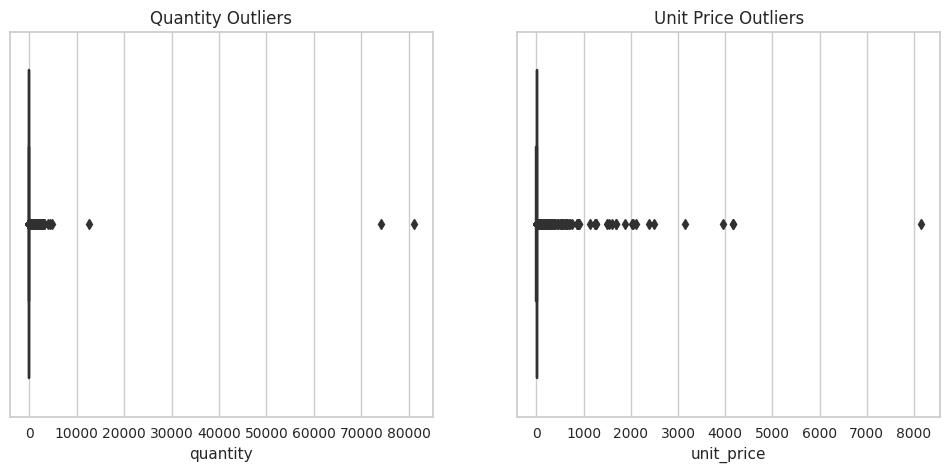

In [29]:
# Boxplot for quantity and unit price
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.boxplot(x=df_v4['quantity'])
plt.title('Quantity Outliers')

plt.subplot(1, 2, 2)
sns.boxplot(x=df_v4['unit_price'])
plt.title('Unit Price Outliers')

plt.show()

In [15]:
# Define function to remove outliers using IQR
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

# Remove outliers from quantity and unit price
df_v5 = remove_outliers(df_v4, 'quantity')
df_v6 = remove_outliers(df_v5, 'unit_price')


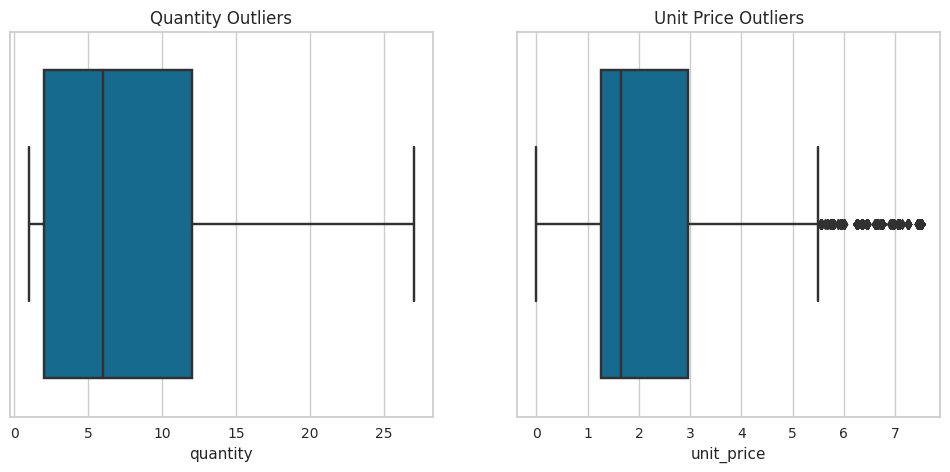

In [30]:
# Boxplot for quantity and unit price
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.boxplot(x=df_v6['quantity'])
plt.title('Quantity Outliers')

plt.subplot(1, 2, 2)
sns.boxplot(x=df_v6['unit_price'])
plt.title('Unit Price Outliers')

plt.show()

In [17]:
df_v6.shape

(333265, 8)

### RFMT


In [31]:
df_v7 = df_v6.copy()
df_v7['total'] = df_v6['quantity'] * df_v6['unit_price']

In [80]:
latest_date = df_v7['invoice_date'].max()

# Create RFM features and Shopping Cycle
RFM = df_v7.groupby('customer_id').agg(
    Recency=('invoice_date', lambda x: (latest_date - x.max()).days),
    Frequency=('invoice_no', 'nunique'),
    Monetary=('total', 'sum'),
    Tenure=('invoice_date', lambda x: (x.max() - x.min()).days)
)

# Calculate Interpurchase Time
RFM['Interpurchase_Time'] = RFM['Tenure'] / RFM['Frequency']

# Create RFMT dataframe with required features
RFMT = RFM[['Recency', 'Frequency', 'Monetary', 'Interpurchase_Time']]


RFMT.head()

,Recency,Frequency,Monetary,Interpurchase_Time
customer_id,,,,
12347,1,7,3314.73,52.142857
12348,248,3,90.2,36.333333
12349,18,1,999.15,0.000000
12350,309,1,294.4,0.000000
12352,35,7,1130.94,37.142857


### Customer Segmentation

In [71]:
# Standardizing the RFMT data
scaler = StandardScaler()
rfmt_scaled = scaler.fit_transform(RFMT)


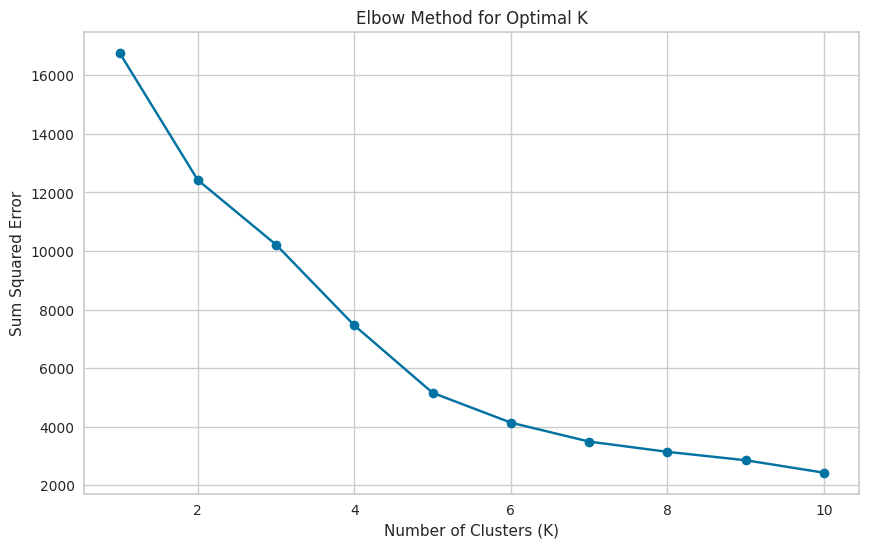

In [72]:
# Finding the optimal number of clusters using the Elbow Method
sse = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(rfmt_scaled)
    sse.append(kmeans.inertia_)

# Plot the elbow graph
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), inertia, marker='o')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Sum Squared Error')
plt.title('Elbow Method for Optimal K')
plt.show()


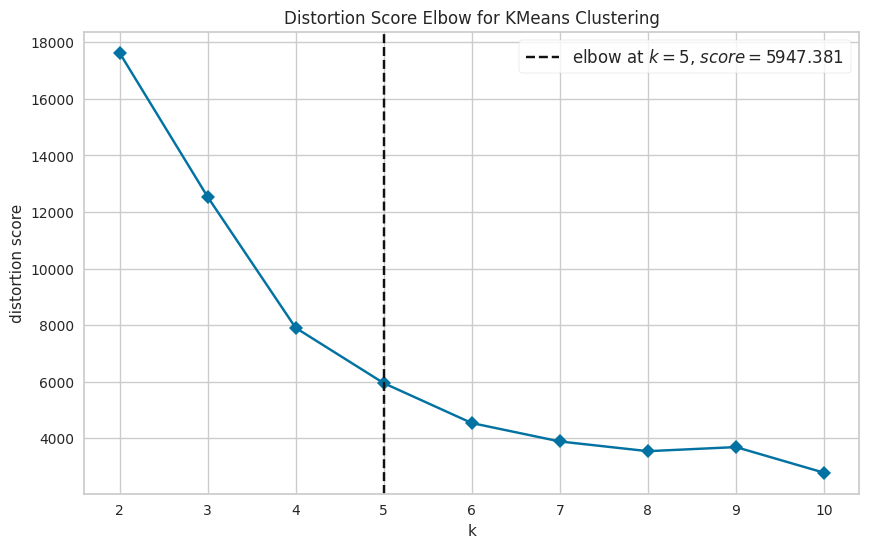

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [77]:
# Finding initial K value using Elbow Method
plt.figure(figsize=(10,6))
Elbow_M = KElbowVisualizer(KMeans(), k=10, timings=False, random_state=42) 
Elbow_M.fit(rfmt_scaled)
Elbow_M.show()

In [81]:
kmeans = KMeans(n_clusters=5, random_state=42)
RFMT['Cluster'] = kmeans.fit_predict(rfmt_scaled)

In [87]:
from sklearn.metrics import silhouette_score
print("Silhouette Score",silhouette_score(rfmt_scaled, kmeans.labels_, metric='euclidean'))

Silhouette score : 0.6358396195449473


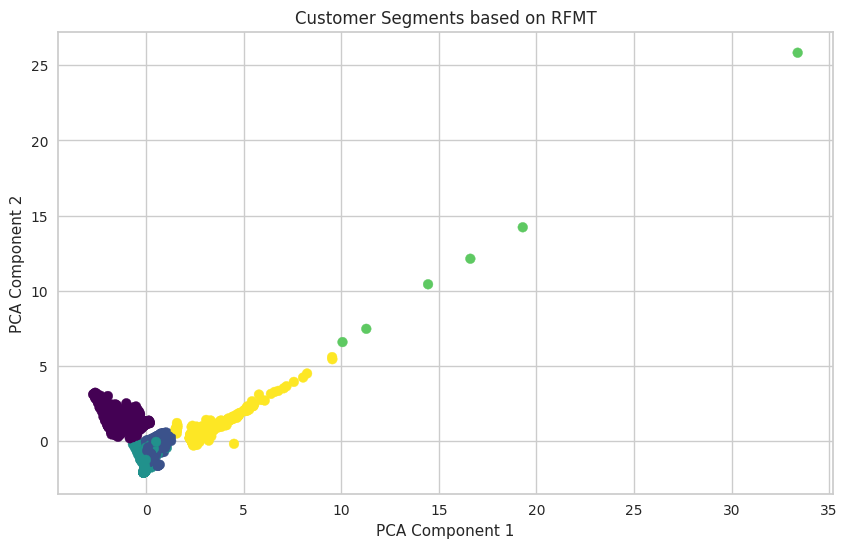

In [83]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
rfmt_pca = pca.fit_transform(rfmt_scaled)

# Plot the clusters
plt.figure(figsize=(10, 6))
plt.scatter(rfmt_pca[:, 0], rfmt_pca[:, 1], c=RFMT['Cluster'], cmap='viridis')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('Customer Segments based on RFMT')
plt.show()


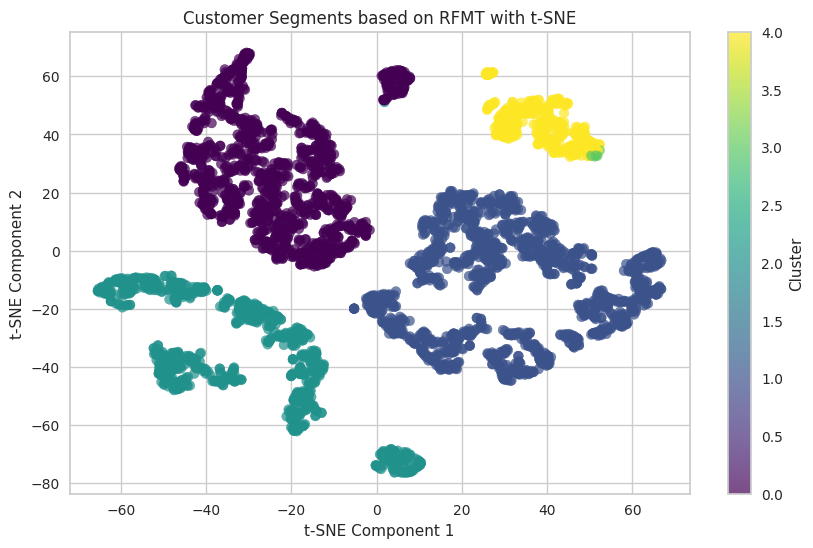

In [84]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42, perplexity=30)
rfmt_tsne = tsne.fit_transform(rfmt_scaled)

# Plot the t-SNE results
plt.figure(figsize=(10, 6))
plt.scatter(rfmt_tsne[:, 0], rfmt_tsne[:, 1], c=RFMT['Cluster'], cmap='viridis', alpha=0.7)
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.title('Customer Segments based on RFMT with t-SNE')
plt.colorbar(label='Cluster')
plt.show()


In [82]:
cluster_analysis = RFMT.groupby('Cluster').mean()
print(cluster_analysis)

            Recency   Frequency      Monetary  Interpurchase_Time
Cluster                                                          
0         46.590007    3.849375    979.839986           71.724111
1         49.736220    2.453412    560.715546           10.510214
2        255.897326    1.444920      291.9906            6.698276
3          1.166667  116.833333  37967.673333            3.531138
4         13.431694   15.860656   4400.454153           24.581588


### **Clusters Interpretation**:
- **Cluster 0**: 
   - Moderate recency and frequency.
   - Moderate monetary value.
   - Larger interpurchase time. 
> Infrequent high-spenders.
- **Cluster 1**:
   - Moderate recency and frequency.
   - Low monetary value.
   - Average interpurchase time. 
> indicating somewhat engaged customers.
- **Cluster 2**:
   - High recency.
   - low frequency and low monetary value.
> Inactive customers or churned.
- **Cluster 3**:
   - Very recent purchases, high frequency and  high monetary value.
> highly engaged, high-value customers.
- **Cluster 4**:
   - Fair recency and frequency, with decent monetary value.
> moderately engaged, valuable customers.

### Marketing Strategy
- **Cluster 0 & 1**: promotional offers to increase frequency, such as discounts on next purchases within defined time frame.
- **Cluster 2**: Win-back campaigns to re-engage, send personalized emails.
- **Cluster 3**: Loyalty programs or exclusive offers for retention.
- **Cluster 4**: Cross/prior purchases recommendations.